## Tune Vitrocal Parameters

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vitrocal.datasets import catalog, ExcelDataset
from vitrocal.preprocessors import StandardPreprocessor
from vitrocal.detectors import DerivativeDetector, StandardExtractor
from vitrocal.analyzers import StandardAnalyzer

Pull out functions from `AnalyzeSingle.py` and work with them interactively

### Load example data file

In [6]:
def load_data(fpath: str | os.PathLike, load_args: dict={}) -> pd.DataFrame:
    """Load single neuron output file.

    Args:
        fpath (str | os.PathLike): Path to single Excel spreadsheet.
        load_args (dict, optional): Passed to `pd.read_excel()`. Defaults to None.

    Returns:
        pd.DataFrame: Dataframe
    """
    fname = os.path.basename(fpath)
    dataset = ExcelDataset.ExcelDataset(fpath, load_args)
    return dataset.load(), fname

In [10]:
df, fname = load_data("../../data/01_raw/E Green.xlsx")
df.head()

,1.000,22.640,14.464,81.846,22.303,5.206,13.008,20.742,14.349,17.126,...,4.038,19.026,6.572,17.669,7.024,2.347,23.887,42.383,4.802,7.620
0,2,21.593,13.584,81.234,19.634,4.756,10.206,17.576,14.729,16.779,...,3.390,19.026,9.156,16.792,7.568,2.142,25.340,41.388,4.140,7.929
1,3,20.348,13.595,81.041,22.261,5.335,9.868,13.821,14.625,16.988,...,4.179,18.215,7.307,17.280,7.383,2.056,27.561,41.679,3.816,6.994
2,4,22.938,13.941,81.420,21.579,5.410,9.857,13.642,14.422,16.672,...,3.982,19.623,7.675,16.628,7.272,2.002,23.300,41.452,3.906,7.850
3,5,20.889,12.441,81.222,20.250,5.081,11.525,12.387,13.078,16.708,...,4.201,19.561,5.383,20.522,7.516,1.527,19.236,46.553,4.277,7.748
4,6,21.691,14.711,81.017,21.015,5.553,11.386,17.477,13.776,16.634,...,3.926,19.548,5.114,18.126,7.079,1.802,23.300,45.417,4.044,7.735


Note: you want to be super careful about loading your files and looking at them first.
These files don't have a header, and sometimes they have numbered rows like this one.


In [12]:
load_args = {'header': None, 'index_col': 0}
df, fname = load_data("../../data/01_raw/E Green.xlsx", load_args)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,143,144,145,146,147,148,149,150,151,152
0,,,,,,,,,,,,,,,,,,,,,
1,22.640,14.464,81.846,22.303,5.206,13.008,20.742,14.349,17.126,36.607,...,4.038,19.026,6.572,17.669,7.024,2.347,23.887,42.383,4.802,7.620
2,21.593,13.584,81.234,19.634,4.756,10.206,17.576,14.729,16.779,35.217,...,3.390,19.026,9.156,16.792,7.568,2.142,25.340,41.388,4.140,7.929
3,20.348,13.595,81.041,22.261,5.335,9.868,13.821,14.625,16.988,35.025,...,4.179,18.215,7.307,17.280,7.383,2.056,27.561,41.679,3.816,6.994
4,22.938,13.941,81.420,21.579,5.410,9.857,13.642,14.422,16.672,36.755,...,3.982,19.623,7.675,16.628,7.272,2.002,23.300,41.452,3.906,7.850
5,20.889,12.441,81.222,20.250,5.081,11.525,12.387,13.078,16.708,36.005,...,4.201,19.561,5.383,20.522,7.516,1.527,19.236,46.553,4.277,7.748


`Vitrocal` is organized into three distinct modules for data analysis:
* `vitrocal.preprocessors`
* `vitrocal.detectors`
* `vitrocal.analyzers`

You'll want to explore the parameter space for each of these individually and assess
the impacts different parameter combinations have on your data.

See [the documentation](https://ajbarrow.w3.uvm.edu/assets/public_share/vitrocal_docs/api/) for details.

### Preprocess

https://ajbarrow.w3.uvm.edu/assets/public_share/vitrocal_docs/api/#vitrocal.preprocessors.StandardPreprocessor   

In [27]:
# change these
fps = 1/2.5
bleach_period = 60
filter_frequency = None
baseline_threshold = 10 # percent
preprocess_window_size = 60 # seconds

# instantiate the StandardPreprocess object with these parameters
preprocessor = StandardPreprocessor(
        frames_per_second=1/2.5,
        bleach_period=bleach_period,
        filter_frequency=filter_frequency,
        baseline_threshold=baseline_threshold,
        window_size=preprocess_window_size
)

In [28]:
# call the object's `preprocess` method
# see the documentation for other methods available

processed = preprocessor.preprocess(df)

No filter applied.


In [17]:
processed.head()

,1,2,3,4,5,6,7,8,9,10,...,143,144,145,146,147,148,149,150,151,152
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.775298,-0.124021,0.415955,-0.550264,16.988480,14.562716,-0.429235,5.028219,-0.037912,4.483730,...,-0.354843,-1.379388,29.830418,-1.180826,-0.764969,-0.439017,-2.199804,-2.723351,4.041916,-0.052597
2,2.023963,-0.212821,-0.011222,9.333163,12.765503,25.899597,17.016534,4.209692,0.514407,1.700227,...,14.667365,5.583899,-1.704634,6.056845,5.919308,-1.222754,20.047789,15.335640,-0.137457,-1.892336
3,8.484906,0.917630,0.134032,3.359750,3.034260,25.182786,1.171024,3.465273,3.941673,1.842744,...,-0.334964,9.272611,1.730721,-0.212424,-0.634158,0.676183,3.921505,8.514650,-1.770144,4.665096
4,1.439772,-1.356012,0.074805,2.403821,-5.240417,-0.059157,1.186546,3.172824,1.152194,1.939269,...,13.946572,2.485965,-4.274594,15.208937,6.919412,0.193507,14.416412,7.647660,3.519521,12.197405


## Detect and Extract

https://ajbarrow.w3.uvm.edu/assets/public_share/vitrocal_docs/api/#vitrocal.detectors.DerivativeDetector   

In [20]:
# change this
threshold = 20 # percent
detector = DerivativeDetector(threshold)

detected = detector.detect(processed)
detected

,1,2,3,4,5,6,7,8,9,10,...,143,144,145,146,147,148,149,150,151,152
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
130,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
131,False,False,False,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Extract: https://ajbarrow.w3.uvm.edu/assets/public_share/vitrocal_docs/api/#vitrocal.detectors.StandardExtractor

Note: the `StandardExtractor` class has a `detect_and_extract` method

In [24]:
# change these
window = (3, 30) # seconds before and after
threshold = 20 # percent

extractor = StandardExtractor(
    window=window,
    frames_per_second=fps, # defined above
    threshold=threshold
)

events = extractor.extract(processed, detected)
events

With FPS = 0.4, a window of (3, 30) seconds captures 1 frame(s) before and 12 frame(s) after each event.


{1: [],
 2: [34    -4.441242
  35    27.219529
  36    21.297873
  37    14.791039
  38    21.044587
  39     2.423687
  40     1.012226
  41     9.942597
  42     6.831427
  43    13.027475
  44    -2.467026
  45     6.515928
  46     6.691205
  47     2.703650
  Name: 2, dtype: float64],
 3: [],
 4: [],
 5: [18     0.252024
  19    21.851080
  20     6.717494
  21    -3.253371
  22     2.722618
  23     8.142943
  24    10.304971
  25    12.030435
  26    11.780970
  27     1.552918
  28    18.619668
  29     7.473368
  30    11.257352
  31    -0.317605
  Name: 5, dtype: float64,
  54     3.084882
  55    38.596155
  56    15.092291
  57    16.741930
  58     1.501087
  59    -1.226114
  60    32.219203
  61    34.059444
  62    37.804121
  63     1.036993
  64    21.540675
  65     7.928806
  66     2.153423
  67    -7.080890
  Name: 5, dtype: float64,
  59    -1.226114
  60    32.219203
  61    34.059444
  62    37.804121
  63     1.036993
  64    21.540675
  65     7.928806
  66  

Note: this method returns events as a Python dictionary. You can examine individual events, if you like:

In [26]:
roi = 2
events[roi]

[34    -4.441242
 35    27.219529
 36    21.297873
 37    14.791039
 38    21.044587
 39     2.423687
 40     1.012226
 41     9.942597
 42     6.831427
 43    13.027475
 44    -2.467026
 45     6.515928
 46     6.691205
 47     2.703650
 Name: 2, dtype: float64]

## Analyze
https://ajbarrow.w3.uvm.edu/assets/public_share/vitrocal_docs/api/#vitrocal.analyzers.StandardAnalyzer

In [31]:
# change these
upper_decay_bound = 0.8 # proportion
lower_decay_bound = 0.2 # proportion

analyzer = StandardAnalyzer(
    upper_decay_bound=upper_decay_bound,
    lower_decay_bound=lower_decay_bound
)

result, avg_result = analyzer.analyze(events)

In [32]:
result

,roi,event,peak,upper,lower,decay
0,2,1.0,27.219529,21.297873269575085,2.423686623870037,18.874187
0,5,1.0,21.851080,6.71749433340203,-3.2533711260707254,9.970865
1,5,2.0,38.596155,15.092290988056458,1.5010871383174555,13.591204
2,5,3.0,37.804121,21.54067458187516,1.0369925070313724,20.503682
3,5,4.0,28.537583,17.316390264914933,NaN,NaN
...,...,...,...,...,...,...
0,151,1.0,21.850508,7.043290726421553,0.46815001841038917,6.575141
1,151,2.0,40.587903,28.518937252685117,5.115884680610503,23.403053
2,151,3.0,30.932655,13.554809584442642,-0.888332099538754,14.443142
3,151,4.0,13.382554,NaN,NaN,NaN


In [33]:
avg_result

,roi,total_events,average_peak,average_decay
0,2,1,27.219529,18.874187
1,5,8,35.123731,14.355113
2,6,20,52.596420,21.558414
3,7,29,67.141770,30.643565
4,13,6,29.688055,14.325707
...,...,...,...,...
106,148,26,66.872413,20.901181
107,149,4,20.964321,10.708524
108,150,12,28.851688,7.623763
109,151,4,26.688405,14.807112


## Plotting

Jupyter notebooks are very helpful for making quick plots to confirm your intuition about an analysis problem. The syntax can be tricky: https://matplotlib.org

[Seaborn](https://seaborn.pydata.org) can make life a little easier, but you generally need to work with `pandas.DataFrames` for the input data.

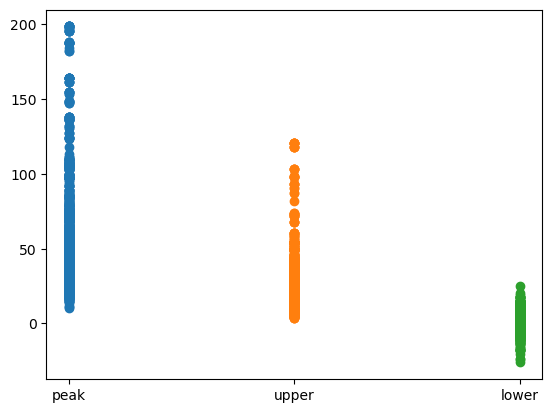

In [89]:
N = len(result)

plt.scatter(np.repeat('peak', N), result['peak'])
plt.scatter(np.repeat('upper', N), result['upper'])
plt.scatter(np.repeat('lower', N), result['lower'])